In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

sns.set(style="whitegrid")

In [2]:
def simulate_algo(algo_name="Fisher",iters=100, num_init_pts=10, pool_sz=10, linearity='1.0', measErr = False):
    variances_df = None
    gains_df = None

    fn_type = "param_diff"
    col_name = "param_diffs"
    
    org_distr = pd.read_csv(f"../data/{algo_name}_param_diff_linearity{linearity}_s{num_init_pts}_b{1}_p{pool_sz}_n{1000}_i{iters}_c{2}_m{measErr}.csv")

    org_distr[col_name] = org_distr[col_name].apply(
        lambda x: np.fromstring(
            x.replace("\n", "").replace("[", "").replace("]", "").replace("  ", " "),
            sep=" ",
        )[1:] # only slope (beta1)
    )
    
    org_distr = org_distr.iloc[num_init_pts:]

    variances = []
    gains = []
    group_col = "Iteration"
    max_iter = max(org_distr['Iteration'].unique()) + 1
    
    grouped = org_distr.groupby([group_col])
    for (name, group) in grouped:
        diffs = group[col_name]
        algo_var = np.var(np.array(diffs), axis=0)
        variances.append(algo_var)
    
    return pd.DataFrame(variances)

In [5]:
def plot_param_sims_mult_poolsz(logscale=False, iters=100, linearity=1.0, measErr = False, axes=None, fig=None):
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]
    poolszs = [10,100,1000] #
    figsz = (25, 6) if len(poolszs) > 1 else (15,10)
    ylabel = r"Variance($\beta$-hat - $\beta$_true)"
    if axes is None:
        fig, axes = plt.subplots(1,len(poolszs), figsize=figsz)
    if fig:
        fig.suptitle(
            f"Variance on Linear Regression Model (lower is better)\n[Params: Linearity: {linearity}; Measurement Error: {measErr}]\n",
            size=30,
        )

    chungus_df = pd.DataFrame()
    for poolsz in poolszs:
        for ax_indx, algo in enumerate(algos):
            print(f'ALGO: {algo}, Pool Sizes: {poolsz}')
            variances_df = simulate_algo(algo, iters=iters, pool_sz=poolsz, linearity=linearity, measErr = measErr)
            variances_df.rename(columns={0:'Variance Difference in Params'}, inplace=True)
            variances_df = variances_df.reset_index().rename(columns={'index': 'Iteration'})
            variances_df['Algorithm'] = algo if algo != "Fisher" else "Our Approach"
            variances_df['Pool Size'] = poolsz
            chungus_df = pd.concat([chungus_df, variances_df])
    chungus_df.reset_index(inplace=True, drop=True)
    chungus_df['Iteration'] += 10
    
    for ax, pool_sz in zip(axes, poolszs):
        data = chungus_df[chungus_df['Pool Size'] == pool_sz]
        ax.set_title(f'Pool Size = {pool_sz}', size=20)
        axplt = sns.lineplot(ax=ax, data=data, x='Iteration', y='Variance Difference in Params', marker="o", lw=3, hue='Algorithm')
        axplt.set_xscale('log')
        axplt.set_yscale('log')
        axplt.set_xlabel('Iterations', size=20)
        axplt.set_ylabel(ylabel, size=20)
        ax.get_legend().remove()

    # Collect all the handles and labels from the subplots
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:  # Add only unique labels
                handles.append(handle)
                labels.append(label)
    
    # Add a single legend below the plots, increase font size
    fig.legend(handles=handles, labels=labels, 
               loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), fontsize=30)

    # Apply tight layout to adjust spacing
    plt.tight_layout()
    
    # Save the figure as a PDF
    path = f'../plots/linreg_i{iters}_l{round(float(linearity)*100)}_m{measErr}'
    plt.savefig(f'{path}.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f"{path}.png", bbox_inches='tight')

    return chungus_df[chungus_df.Iteration == 0]

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Variance Difference in Params,Algorithm,Pool Size


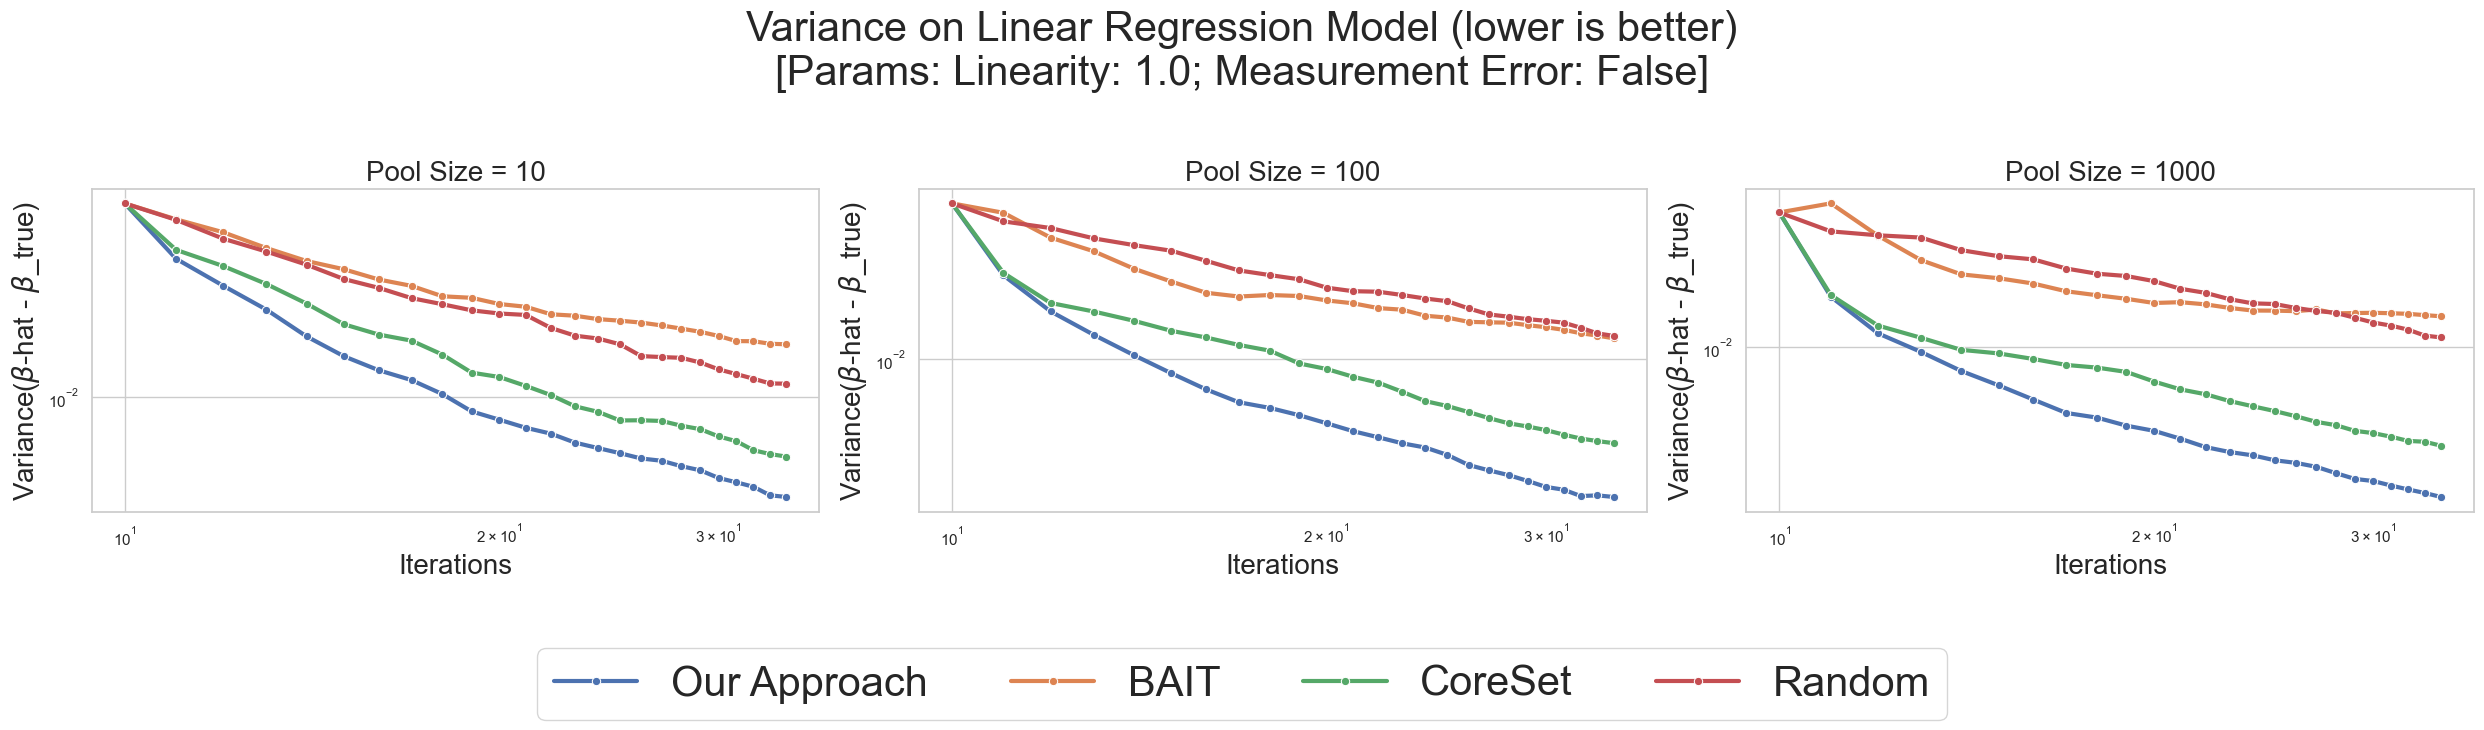

In [6]:
plot_param_sims_mult_poolsz(logscale=True, iters=25, linearity='1.0', measErr=False)

ALGO: Fisher, Pool Sizes: 10
ALGO: BAIT, Pool Sizes: 10
ALGO: CoreSet, Pool Sizes: 10
ALGO: Random, Pool Sizes: 10
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 1000
ALGO: BAIT, Pool Sizes: 1000
ALGO: CoreSet, Pool Sizes: 1000
ALGO: Random, Pool Sizes: 1000


,Iteration,Variance Difference in Params,Algorithm,Pool Size


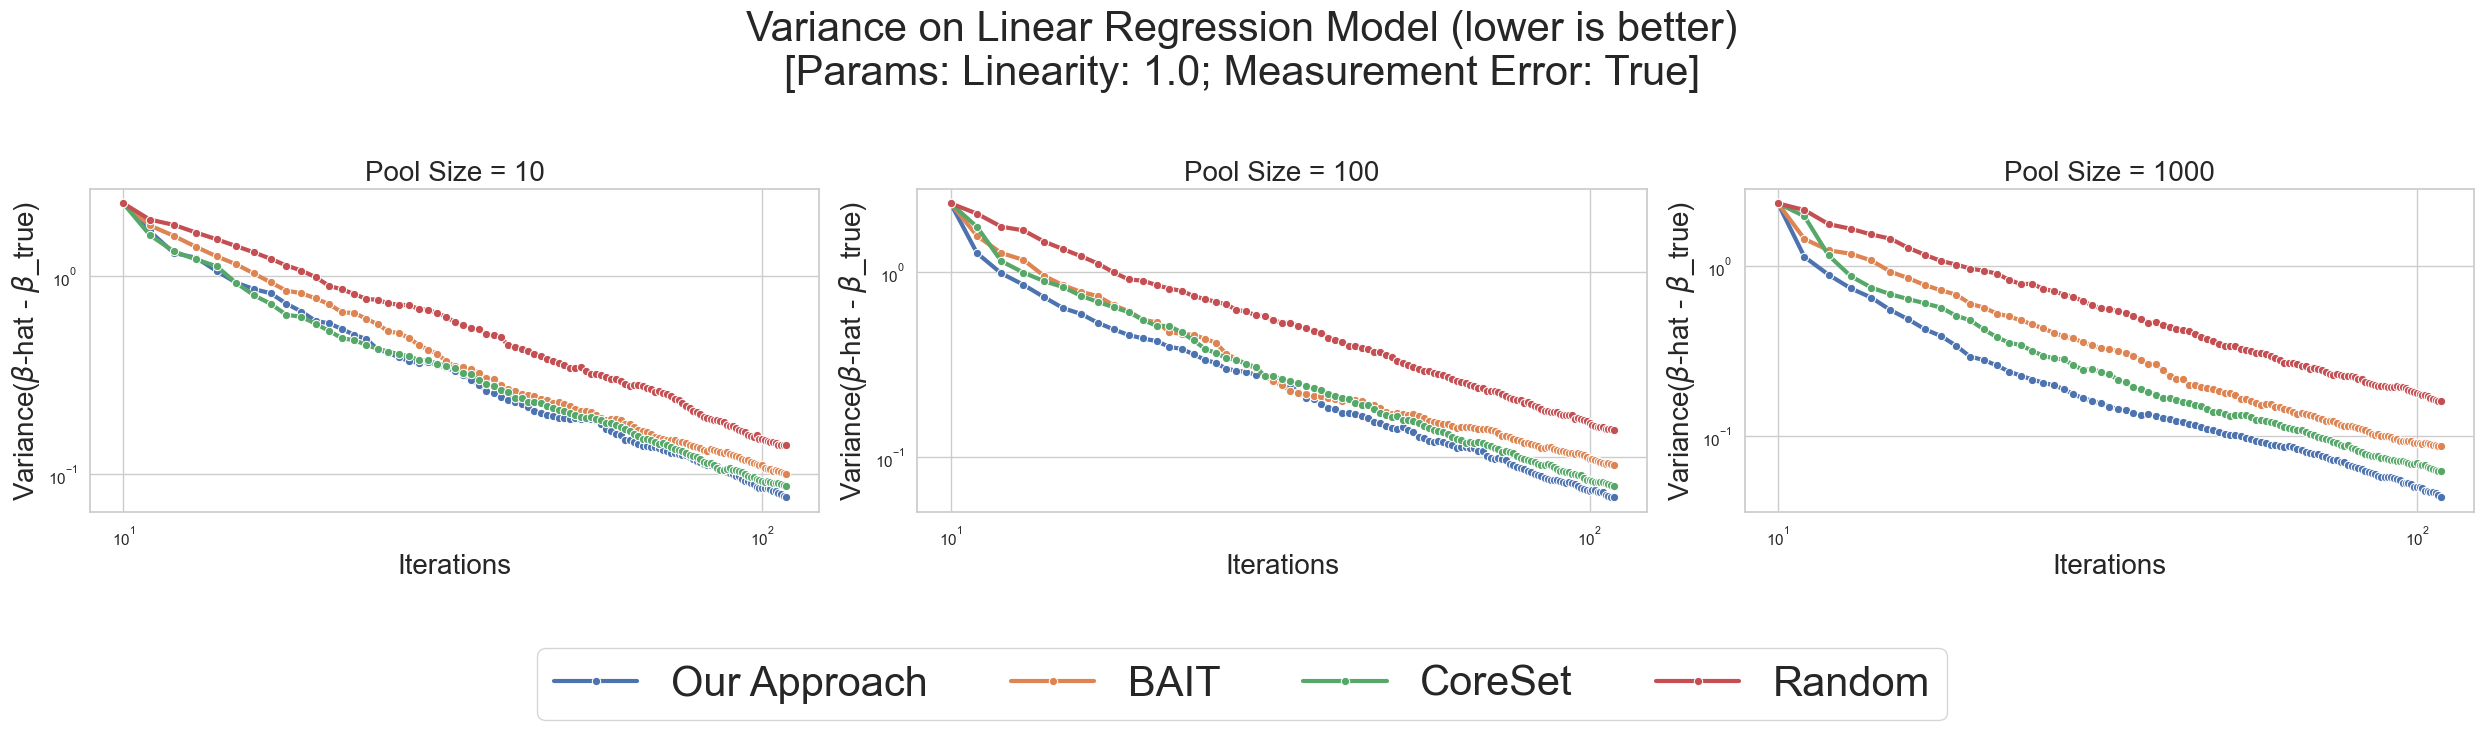

In [7]:
plot_param_sims_mult_poolsz(logscale=True, iters=100, linearity='1.0', measErr=True)

In [8]:
def nonlinear_exp(axes, logscale=False, poolsz=100, iters=100, linearity=1.0, measErr = False):  
    algos = ["Fisher", "BAIT", "CoreSet", "Random"]  #
    ylabel = r"Variance($\beta$-hat - $\beta$_true)"

    chungus_df = pd.DataFrame()
    for ax_indx, algo in enumerate(algos):
        print(f'ALGO: {algo}, Pool Sizes: {poolsz}')
        variances_df = simulate_algo(algo, iters=iters, pool_sz=poolsz, linearity=linearity, measErr = measErr)
        variances_df.rename(columns={0:'Variance Difference in Params'}, inplace=True)
        variances_df = variances_df.reset_index().rename(columns={'index': 'Iteration'})
        variances_df['Algorithm'] = algo if algo != "Fisher" else "Our Approach"
        variances_df['Pool Size'] = poolsz
        chungus_df = pd.concat([chungus_df, variances_df])
    chungus_df.reset_index(inplace=True, drop=True)
    chungus_df['Iteration'] += 10
    
    axes.set_title(
        r"$\lambda$ = "+f"{linearity}\n",
        size=30,
    )
    data = chungus_df[chungus_df['Pool Size'] == poolsz]
    axplt = sns.lineplot(ax=axes, data=data, x='Iteration', y='Variance Difference in Params', marker="o", lw=3, hue='Algorithm')
    axplt.set_xscale('log')
    axplt.set_yscale('log')
    axplt.set_ylabel(ylabel, size=20)
    axplt.set_xlabel("Iteration", size=20)
    
    line1 = data[data['Algorithm'] == 'BAIT'] if float(linearity) < 1.0 else data[data['Algorithm'] == 'CoreSet']
    line2 = data[data['Algorithm'] == 'Our Approach']
    
    # Calculate where the two lines intersect (find the closest y-values)
    x_vals = line1['Iteration'].values[1:]
    y1_vals = line1['Variance Difference in Params'].values[1:] 
    y2_vals = line2['Variance Difference in Params'].values[1:] 
    diff = np.abs(y1_vals - y2_vals)
    intersection_index = np.argmin(diff)
    
    # Get intersection coordinates
    intersection_x = x_vals[intersection_index]
    intersection_y = y1_vals[intersection_index]
    # Add a vertical line at the intersection point
    axplt.axvline(x=intersection_x, color='black', linestyle='--', label=f'Crossover at numIters={intersection_x:.2f}')
    
    # Optionally, add a label or annotation at the intersection
    axplt.text(intersection_x, intersection_y, f'(numPts = {intersection_x:.2f})', 
               color='black', fontsize=14, ha='left') # 

    return chungus_df[chungus_df.Iteration == 0]

ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100
ALGO: Fisher, Pool Sizes: 100
ALGO: BAIT, Pool Sizes: 100
ALGO: CoreSet, Pool Sizes: 100
ALGO: Random, Pool Sizes: 100


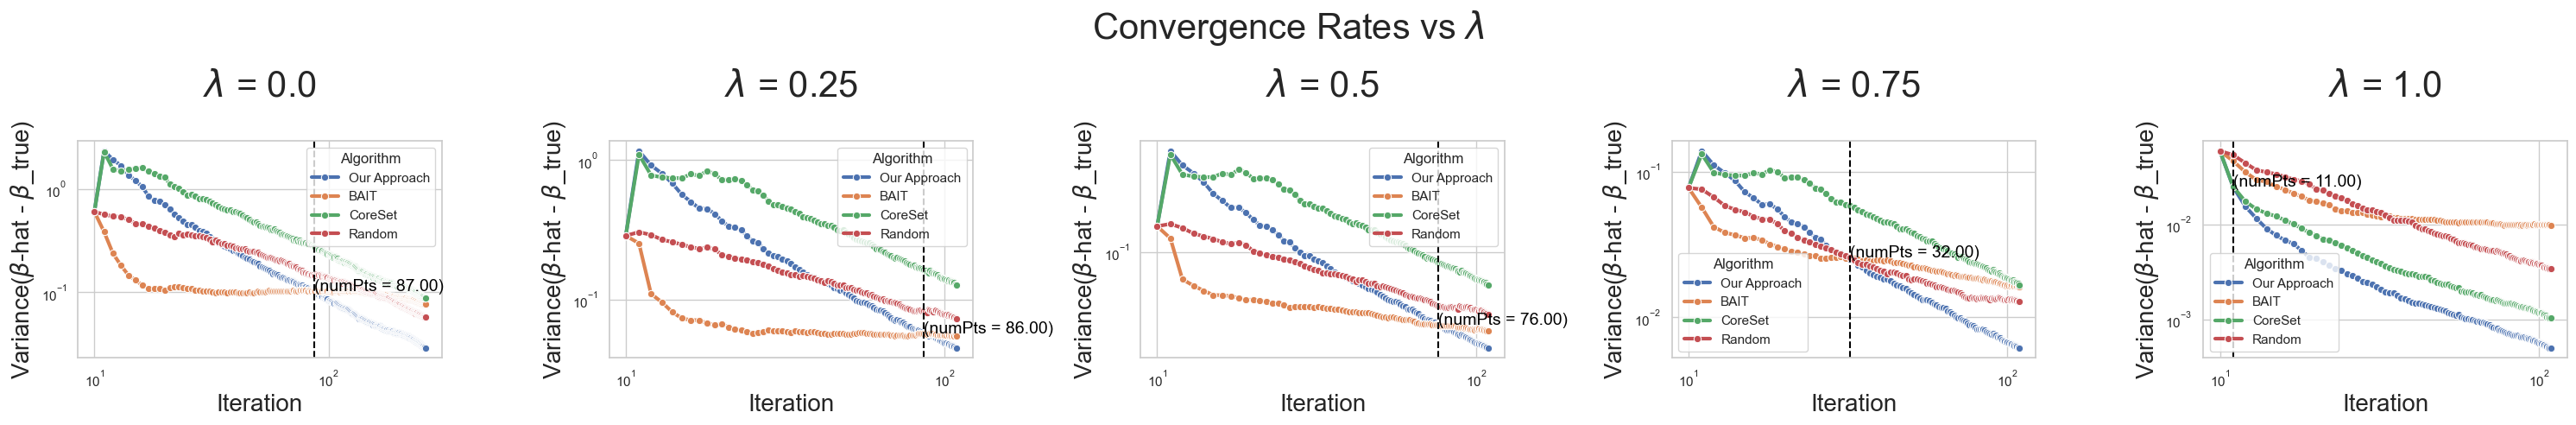

In [9]:
def plot_all_nonlin_exp():
    # Create a figure with a 5x1 grid of subplots (5 rows, 1 column)
    fig, axs = plt.subplots(1, 5, figsize=(30, 5))  # Adjust figsize as needed
    
    fig.suptitle(r"Convergence Rates vs $\lambda$", size=30)
    
    # Call plot_param_sims for each set of parameters and assign to different subplots
    nonlinear_exp(logscale=True, iters=250, linearity='0.0', measErr=False, axes=axs[0])
    nonlinear_exp(logscale=True, iters=100, linearity=0.25, measErr=False, axes=axs[1])
    nonlinear_exp(logscale=True, iters=100, linearity=0.5, measErr=False, axes=axs[2])
    nonlinear_exp(logscale=True, iters=100, linearity=0.75, measErr=False, axes=axs[3])
    nonlinear_exp(logscale=True, iters=100, linearity=1.0, measErr=False, axes=axs[4])
    
    # Adjust the layout to avoid overlap
    # Apply tight layout to adjust spacing
    plt.tight_layout()
    
    # Save the figure as a PDF
    plt.savefig('../plots/nonlinear.pdf', format='pdf')
    plt.savefig("../plots/nonlinear.png")
    plt.show()
plot_all_nonlin_exp()

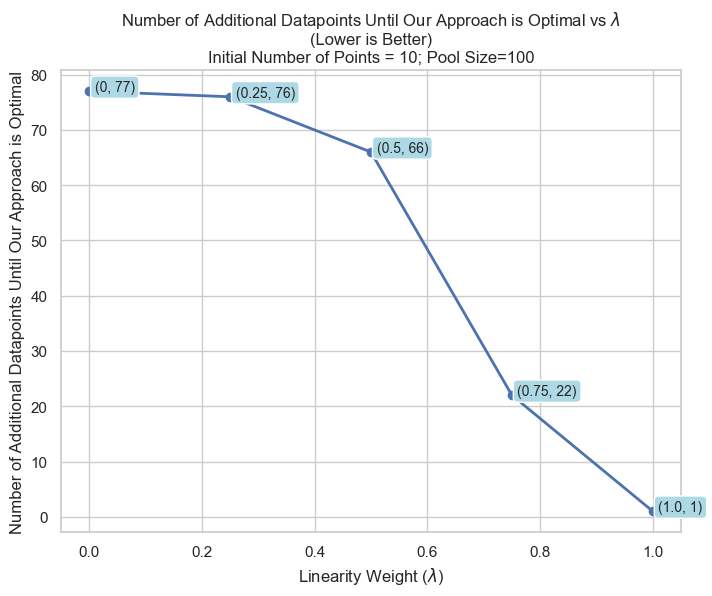

In [10]:
x = [0, 0.25, 0.5, 0.75, 1.0]
y = np.array([87, 86, 76, 32, 11]) # number of datapoints (including initial_sz = 10)
y -= 10
plt.figure(figsize=(8, 6))
plt.plot(x, y, linewidth=2, marker='o')
plt.xlabel(r"Linearity Weight ($\lambda$)")
plt.ylabel("Number of Additional Datapoints Until Our Approach is Optimal")
plt.title(r"Number of Additional Datapoints Until Our Approach is Optimal vs $\lambda$" + "\n(Lower is Better)\nInitial Number of Points = 10; Pool Size=100")
for i in range(len(x)):
    plt.text(x[i] + 0.01, y[i] + 0.01, f'({x[i]}, {y[i]})', fontsize=10, bbox=dict(facecolor='lightblue', boxstyle='round,pad=0.3'))

# Save the figure as a PDF
plt.savefig('../plots/nonlinear_iters.pdf', format='pdf')
plt.savefig("../plots/nonlinear_iters.png")
plt.show()

In [28]:
def plot_gain_ratios(ax, pool_sz, iters=500, measErr=False):
    df = pd.read_csv(f'../data/variancesDf_linearity1.0_s10_b1_p{pool_sz}_n1_i{iters}_c2_m{measErr}.csv')
    df['Iteration'] += 10
    df['Gain Ratio'] = df.apply(lambda row: row['Var(Labeled Points)'] / (df.loc[(df['Algorithm'] == 'Random') & (df['Iteration'] == row.Iteration)].reset_index(drop=True).iloc[0]['Var(Labeled Points)']) , axis=1)
    max_iters = max(df['Iteration'])
    for algo in df['Algorithm'].unique():
        mini_df = df[df.Algorithm == algo]
        max_gain = mini_df['Gain Ratio'].max()
        print(f"{algo} PoolSz: {pool_sz} -- Max GR = {max_gain:.2f}")
    
    axplt = sns.lineplot(data=df, x='Iteration', y='Gain Ratio', hue='Algorithm', ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Iteration', size=20)
    ax.set_ylabel('Gain Ratio', size=20)
    ax.get_legend().remove()
    
def plot_gain_ratios_mult_poolSz(iters=500, measErr=False):
    poolszs = [10,100,1000]
    fig, axes = plt.subplots(1, len(poolszs), figsize=(15,6), sharey=True)
    fig.suptitle(r"Comparison of Sampling Algorithms' Gain Ratios $\left(\frac{Var(\widetilde{X}_{algo})}{Var(X_{random})}\right)$"+f"\n(Higher is Better)\n[Initial Number of Points = 10, {'' if measErr else 'No'} Measurement Error]", size=20)
    for ax, pool_sz in zip(axes, poolszs):
        plot_gain_ratios(ax, pool_sz, iters, measErr)

    # Collect all the handles and labels from the subplots
    handles, labels = [], []
    for ax in axes:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:  # Add only unique labels
                handles.append(handle)
                labels.append(label)
    
    # Add a single legend below the plots, increase font size
    fig.legend(handles=handles, labels=labels, 
               loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels), fontsize=20)
    
    plt.tight_layout()
    plt.savefig(f'../plots/gain_plot_m{measErr}.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(f"../plots/gain_plot_m{measErr}.pdf", bbox_inches='tight')
    plt.show()
    

Our Approach PoolSz: 10 -- Max GR = 3.23
BAIT PoolSz: 10 -- Max GR = 1.58
CoreSet PoolSz: 10 -- Max GR = 2.02
Random PoolSz: 10 -- Max GR = 1.00
Our Approach PoolSz: 100 -- Max GR = 7.02
BAIT PoolSz: 100 -- Max GR = 2.35
CoreSet PoolSz: 100 -- Max GR = 3.69
Random PoolSz: 100 -- Max GR = 1.00
Our Approach PoolSz: 1000 -- Max GR = 10.71
BAIT PoolSz: 1000 -- Max GR = 3.58
CoreSet PoolSz: 1000 -- Max GR = 5.30
Random PoolSz: 1000 -- Max GR = 1.00


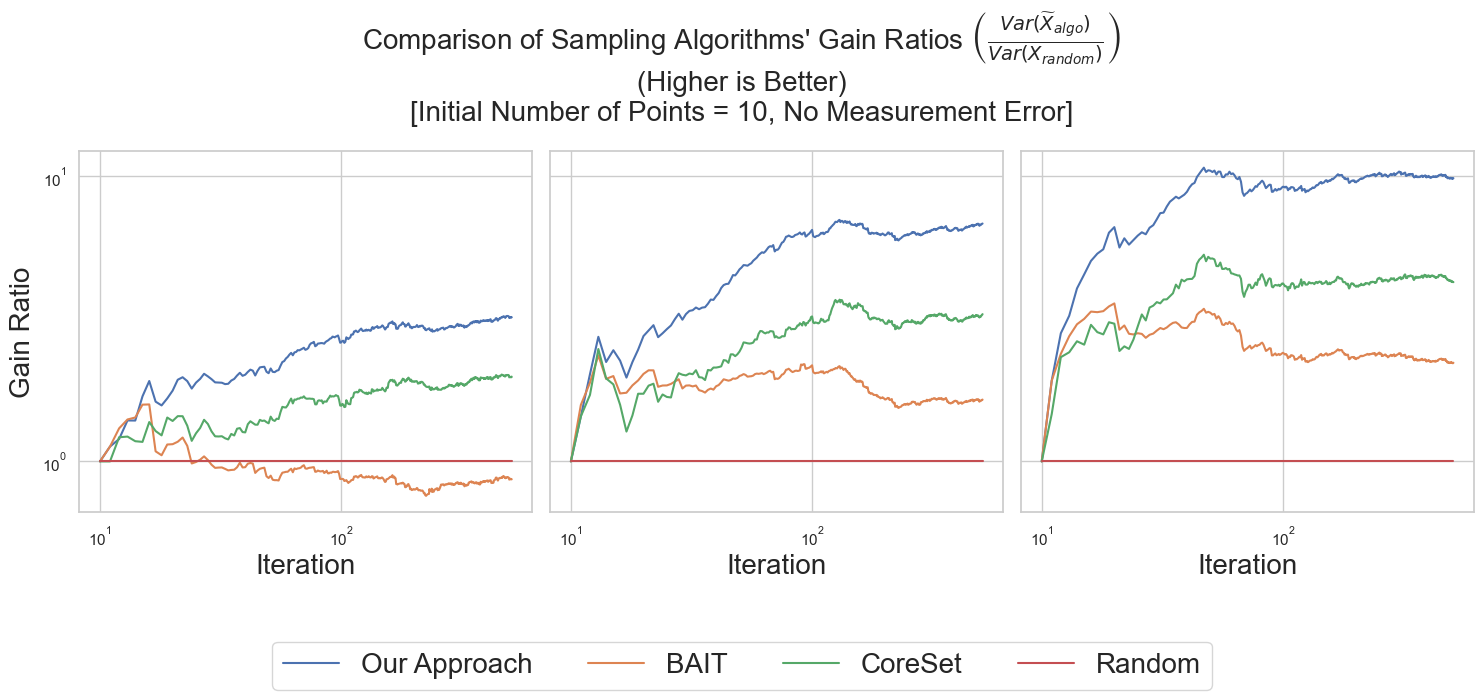

In [29]:
plot_gain_ratios_mult_poolSz()